### Test 3
## Novel view synthesis with 3D-Diffusion
Combining the previous two tests, we attempt to improve text-to-3d with multiple synthetic views starting from a text prompt.
We use [3D Diffusion (Watson et al. 2022)](https://arxiv.org/abs/2210.04628), a generative model that given an image and (R, t) matrices, it generates a novel view for that object (it works also in a autoregressive way). 

<img src="../img/3d_diffusion.png" alt= "Stable-Point-E Pipeline" width="700px">

Since training this model took hundreds of GPU hours, a pre-trained version is available, but only for the SRN Cars dataset. Currently we are taking part in the collaborative effort of training and publishing an open source of 3D Diffusion with the LAION AI group ([code](https://github.com/halixness/distributed-3d-diffusion-pytorch))([dataset](https://github.com/LAION-AI/laion-3d)).  

In [3]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

In [4]:
# Initial parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_images = []
num_views = 4

### Single view text-to-img with Stable Diffusion 2

In [4]:
img_size = 512
border = 100
background_color = 255

# Starting image is a square on white bg
booth = np.ones((img_size, img_size,3))*background_color
booth[border:img_size-border,border:img_size-border,:] = 0
booth = Image.fromarray(booth.astype(np.uint8()))

mask = np.zeros((img_size,img_size,3))
mask[border:img_size-border,border:img_size-border,:] = 255
mask = Image.fromarray(mask.astype(np.uint8()))

In [6]:
tensor2img = transforms.ToPILImage()
img2tensor = transforms.PILToTensor()

In [5]:
# Inpainting with stable diffusion 2
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

text_encoder\model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
# Prompt engineering and low resolution image generation
prompt = "a red sportscar"
prompt_details = ", full body frontal camera view, white background, blender render, high resolution, standard light, no reflections"
dim3_img_size = 64

input_image = pipe(prompt=prompt + prompt_details, image=booth, mask_image=mask).images[0].resize((dim3_img_size, dim3_img_size))

  0%|          | 0/50 [00:00<?, ?it/s]

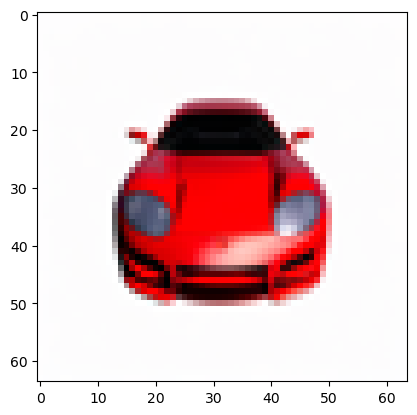

In [8]:
plt.imshow(input_image)

In [9]:
input_image = img2tensor(input_image) / 255 * 2 - 1

### Novel view synthesis with 3D Diffusion

In [10]:
# Saving GPU memory
torch.cuda.empty_cache()
del pipe

In [11]:
from xunet import XUNet

from random import randrange
import torch
import torch.nn.functional as F

from tqdm import tqdm
from einops import rearrange
import time

from SRNdataset import dataset, MultiEpochsDataLoader
from tensorboardX import SummaryWriter
import os
import glob
from PIL import Image
import random

**Note:** this cell of code mainly comes from the official implementation of k-diffusion by Katherine Crowson ([code](https://github.com/crowsonkb/k-diffusion)).

In [12]:
def logsnr_schedule_cosine(t, *, logsnr_min=-20., logsnr_max=20.):
    b = np.arctan(np.exp(-.5 * logsnr_max))
    a = np.arctan(np.exp(-.5 * logsnr_min)) - b
    
    return -2. * torch.log(torch.tan(a * t + b))

# -----------------------------------------------------

def xt2batch(x, logsnr, z, R, T, K):
    b = x.shape[0]
    return {
        'x': x.cuda(),
        'z': z.cuda(),
        'logsnr': torch.stack([logsnr_schedule_cosine(torch.zeros_like(logsnr)), logsnr], dim=1).cuda(),
        'R': R.cuda(),
        't': T.cuda(),
        'K':K[None].repeat(b,1,1).cuda(),
    }

# ----------------------- Diffusion forward process -----------------------

@torch.no_grad()
def sample(model, record, target_R, target_T, K, w, timesteps=256):
    """
        Forward process
        record: first view of the object with (R, t)
        target_R, target_T: given these rotations, predict the view
    """
    b = w.shape[0]
    img = torch.randn_like(torch.tensor(record[0][0]))
    
    logsnrs = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[:-1])
    logsnr_nexts = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[1:])
    
    for logsnr, logsnr_next in tqdm(zip(logsnrs, logsnr_nexts), total=len(logsnrs), desc='diffusion loop', position=1, leave=False): # [1, ..., 0] = size is 257
        condition_img, condition_R, condition_T = random.choice(record)
        condition_img = torch.tensor(condition_img)
        condition_R = torch.tensor(condition_R)
        condition_T = torch.tensor(condition_T)
        
        R = torch.stack([condition_R, target_R], 0)[None].repeat(b, 1, 1, 1)
        T = torch.stack([condition_T, target_T], 0)[None].repeat(b, 1, 1)
        condition_img = condition_img
        img = p_sample(model,
                       z=img,
                       x=condition_img, 
                       R=R,
                       T=T,
                       K=K,
                       logsnr=logsnr, logsnr_next=logsnr_next,
                       w=w)
        
    return img.cpu().numpy()

# -----------------------------------------------------

def q_sample(z, logsnr, noise):
    """
        Forward: q(x_t|x_0)
    """
    # lambdas = logsnr_schedule_cosine(t)
    
    alpha = logsnr.sigmoid().sqrt()
    sigma = (-logsnr).sigmoid().sqrt()
    
    alpha = alpha[:,None, None, None]
    sigma = sigma[:,None, None, None]

    return alpha * z + sigma * noise


# ----------------------- Diffusion backward process -----------------------

@torch.no_grad()
def p_sample(model, x, z, R, T, K, logsnr, logsnr_next, w):
    """
        Backward process: epsilon_0(x_t, t)
    """
    
    model_mean, model_variance = p_mean_variance(model, x=x, z=z, R=R, T=T, K=K, logsnr=logsnr, logsnr_next=logsnr_next, w=w)
    
    if logsnr_next==0:
        return model_mean
    
    return model_mean + model_variance.sqrt() * torch.randn_like(x).cpu()

# -----------------------------------------------------

@torch.no_grad()
def p_mean_variance(model, x, z, R, T, K, logsnr, logsnr_next, w=2.0):
    """
        Backward process (and variance)
    """
    
    strt = time.time()
    b = x.shape[0]
    w = w[:, None, None, None]
    
    c = - torch.special.expm1(logsnr - logsnr_next)

    squared_alpha, squared_alpha_next = logsnr.sigmoid(), logsnr_next.sigmoid()
    squared_sigma, squared_sigma_next = (-logsnr).sigmoid(), (-logsnr_next).sigmoid()
    
    alpha, sigma, alpha_next = map(lambda x: x.sqrt(), (squared_alpha, squared_sigma, squared_alpha_next))
    
    # batch = xt2batch(x, logsnr.repeat(b), z, R)
    batch = xt2batch(x, logsnr.repeat(b), z, R, T, K)
    
    strt = time.time()

    # Predicted noise
    pred_noise = model(batch, cond_mask= torch.tensor([True]*b)).detach().cpu()
    batch['x'] = torch.randn_like(x).cuda()
    pred_noise_unconditioned = model(batch, cond_mask= torch.tensor([False]*b)).detach().cpu()
    
    pred_noise_final = (1+w) * pred_noise - w * pred_noise_unconditioned
    
    z = z.detach().cpu()
    
    # actual predicted x_0
    z_start = (z - sigma * pred_noise_final) / alpha
    z_start.clamp_(-1., 1.)
    
    model_mean = alpha_next * (z * (1 - c) / alpha + c * z_start)
    
    posterior_variance = squared_sigma_next * c
    
    return model_mean, posterior_variance

# -----------------------------------------------------

def p_losses(denoise_model, img, R, T, K, logsnr, noise=None, loss_type="l2", cond_prob=0.1):
    """
        Backward process loss: E[|| epsilon - epsilon_0(x_t, t)||]
    """
    B = img.shape[0]
    x = img[:, 0]
    z = img[:, 1]
    if noise is None:
        noise = torch.randn_like(x)

    z_noisy = q_sample(z=z, logsnr=logsnr, noise=noise)
    
    
    cond_mask = (torch.rand((B,)) > cond_prob).cuda()
    
    x_condition = torch.where(cond_mask[:, None, None, None], x, torch.randn_like(x))
    
    batch = xt2batch(x=x_condition, logsnr=logsnr, z=z_noisy, R=R, T=T, K=K)
    
    predicted_noise = denoise_model(batch, cond_mask=cond_mask.cuda())

    if loss_type == 'l1':
        loss = F.l1_loss(noise.to(device), predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise.to(device), predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise.to(device), predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [13]:
# Model pre-trained on SRN-cars
pretrained_model = "trained_model.pt"
model = XUNet(H=dim3_img_size, W=dim3_img_size, ch=128)
model = torch.nn.DataParallel(model)
model.to(device)

ckpt = torch.load(pretrained_model)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [15]:
import os, random

base_path = os.path.join("..", "..", "distributed-3d-diffusion-pytorch", "data", "SRN", "cars_train")
samples = os.listdir(base_path)

# Get one random sample from SRN cars dataset
idx = random.randint(1, len(samples))
imgsize = 64

# Collection of (view, rotation matrix, translation matrix) of the object
data_imgs = []
data_Rs = []
data_Ts = []
    
# For all the available views for that sample
for root, dirs, files in os.walk(os.path.join(base_path, samples[idx], "rgb")):
    for f in sorted(files):
        # View
        img = Image.open(os.path.join(base_path, samples[idx], "rgb", f))
        img = img.resize((imgsize, imgsize))
        img = np.array(img) / 255 * 2 - 1
        img = img.transpose(2,0,1)[:3].astype(np.float32)
        data_imgs.append(img)
    
        # Rotation/translation matrix parsing
        pose_filename = os.path.join(base_path, samples[idx], "pose", f)[:-4]+".txt"
        pose = np.array(open(pose_filename).read().strip().split()).astype(float).reshape((4,4))

        data_Rs.append(pose[:3, :3])
        data_Ts.append(pose[:3, 3])

# read the last sample's calibration matrix as default (from paper implementation)
data_K = np.array(
    open(
        os.path.join(
            base_path, samples[idx], "intrinsics", f[:-4]+".txt"
        )
    ).read().strip().split()).astype(float).reshape((3,3)
)

data_K = torch.tensor(data_K)

In [16]:
# sample, channel, width, height
print("data_imgs \t", torch.Tensor(data_imgs).size())

# sample, 3, 3
print("data_R \t\t", torch.Tensor(data_Rs).size())

# sample, 3
print("data_T \t\t", torch.Tensor(data_Ts).size())


# sample, 3, 3
print("data_K \t\t", torch.Tensor(data_K).size())

data_imgs 	 torch.Size([250, 3, 64, 64])
data_R 		 torch.Size([250, 3, 3])
data_T 		 torch.Size([250, 3])
data_K 		 torch.Size([3, 3])


C:\Users\xdieg\AppData\Local\Temp\ipykernel_19816\1735239327.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  print("data_imgs \t", torch.Tensor(data_imgs).size())


In [17]:
# Count of images to generate
w = torch.tensor([0])
b = w.shape[0]

# Input img pose
input_image_pose = np.array(open("pose.txt").read().strip().split()).astype(float).reshape((4,4))

# Take the Stable Diffusion synthetic, single view and concat the initial pose (provided with file)
record = [[
    np.expand_dims(np.asarray(input_image).repeat(b, axis=0), 0), 
    input_image_pose[:3, :3],
    input_image_pose[:3, 3],
]]

In [18]:
# takes the first image, repeat it x images to generate times
# take the Rotation of first image
# take the position of first image
torch.Tensor(record[0][0]).size()

torch.Size([1, 3, 64, 64])

In [ ]:
with torch.no_grad():
    step = 1
    start_idx = 0
    end_idx = num_views
    
    # For each (view, rotation, translation)
    for gt, R, T in tqdm(zip(data_imgs[start_idx:end_idx], data_Rs[start_idx:end_idx], data_Ts[start_idx:end_idx]), total=len(data_imgs[start_idx:]), desc='view loop', position=0):
        R = torch.tensor(R)
        T = torch.tensor(T)

        """
            record: first view of the object, (img, R, t)
            target_R, target_T: given these rotations, predict the view
            data_K: just ONE calibration matrix (original code picks the last intrinsics)
        """
        img = sample(model, record=record, target_R=R, target_T=T, K=data_K, w=w)

        # augment the conditioning record with the generated ones => autoregressive
        record.append([img, R.cpu().numpy(), T.cpu().numpy()])

        # we have generated w.size() views! (one by default)
        for i in w:
            generated_view = ((img[0].transpose(1,2,0)+1)*127.5).astype(np.uint8)
            generated_images.append(tensor2img(generated_view))
        
        step += 1

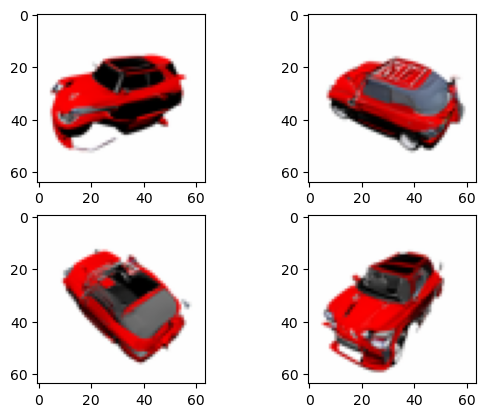

In [20]:
cols = 2
rows = (num_views // cols)
f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(generated_images[i])

In [38]:
for i, img  in enumerate(generated_images):
    img.save("{:04d}.png".format(i))

### Point cloud generation with synthetic multi views

In [35]:
torch.cuda.empty_cache()

In [6]:
# may require to install the pkg from the root with pip install -e .
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

Strange thing: even though the num. tokens is changed, the transformer still loads the pre-trained weights and it also accepts inputs with a different number of tokens.

In [7]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

# Initializing multi-view POINT-E
MODEL_CONFIGS[base_name]["n_views"] = num_views
MODEL_CONFIGS['upsample']["n_views"] = num_views

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [9]:
# loading stored synth.views in a second run cuz my gpu died
for idx in range(num_views):
    generated_images.append(Image.open("{:04d}.png".format(idx)))

In [10]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=generated_images))):
    samples = x

0it [00:00, ?it/s]

In [11]:
samples.shape

torch.Size([1, 6, 4096])

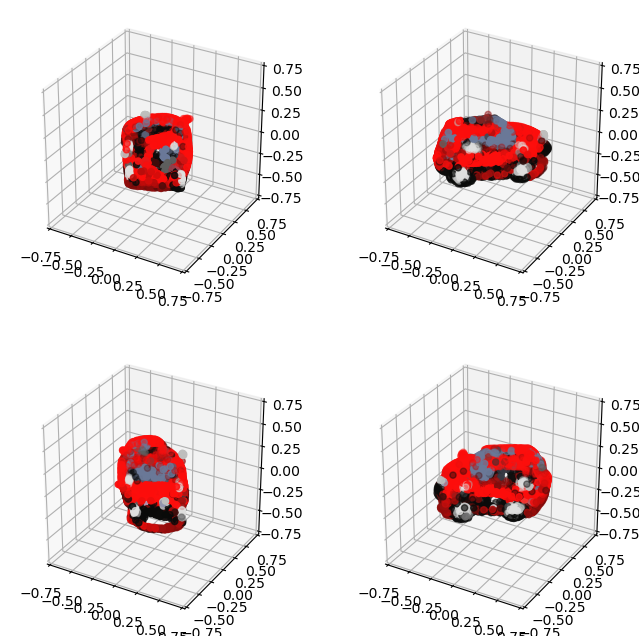

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))